Here's a quick tutorial on how to use the GOODS south mosaic to simulate grism images. You should have all the packages listed except for Readfile, which I made, and maybe seaborn. You can replace Readfile with any package that reads in files. Seaborn is just used to make plots look nicer so you can ignore it. 

The only other package that could give you problems is pysynphot. If it does look it up online and make sure you've downloaded all the necessary files for it. 

In [1]:
import grizli
import numpy as np
from sim_tools import Scale_model
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import fits
import astropy.wcs as pywcs
import pysynphot as S
import seaborn as sea

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [59]:
## set flt file, we're using a good example galaxy
flt_input = 's47677_flt.fits' 

## Create Grizli model object
sim_g102 = grizli.model.GrismFLT(grism_file='', verbose=False,
                                         direct_file=flt_input,
                                         force_grism='G102')

Read in the main catalog, then use blot_catalog to create flt catalog.

In [60]:
sim_g102.photutils_detection(detect_thresh=.025, verbose=True, save_detection=True)

keep = sim_g102.catalog['mag'] < 29
c = sim_g102.catalog

s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
s47677_flt: photutils.source_properties - 1 objects
s47677_flt: save s47677_flt.detect_seg.fits, s47677_flt.detect.cat


Compute the full model. You could filter by magnitude like in the demos, but it's not totally necessary.

In [61]:
sim_g102.compute_full_model(ids=c['id'][keep], mags=c['mag'][keep], verbose=False)

Pick the source using its ID from the catalog.

In [64]:
## Grab object near the center of the image
dr = np.sqrt((sim_g102.catalog['x_flt'] - 579) ** 2 + (sim_g102.catalog['y_flt'] - 522) ** 2)
ix = np.argmin(dr)
gid = sim_g102.catalog['id'][ix]

Get cutout

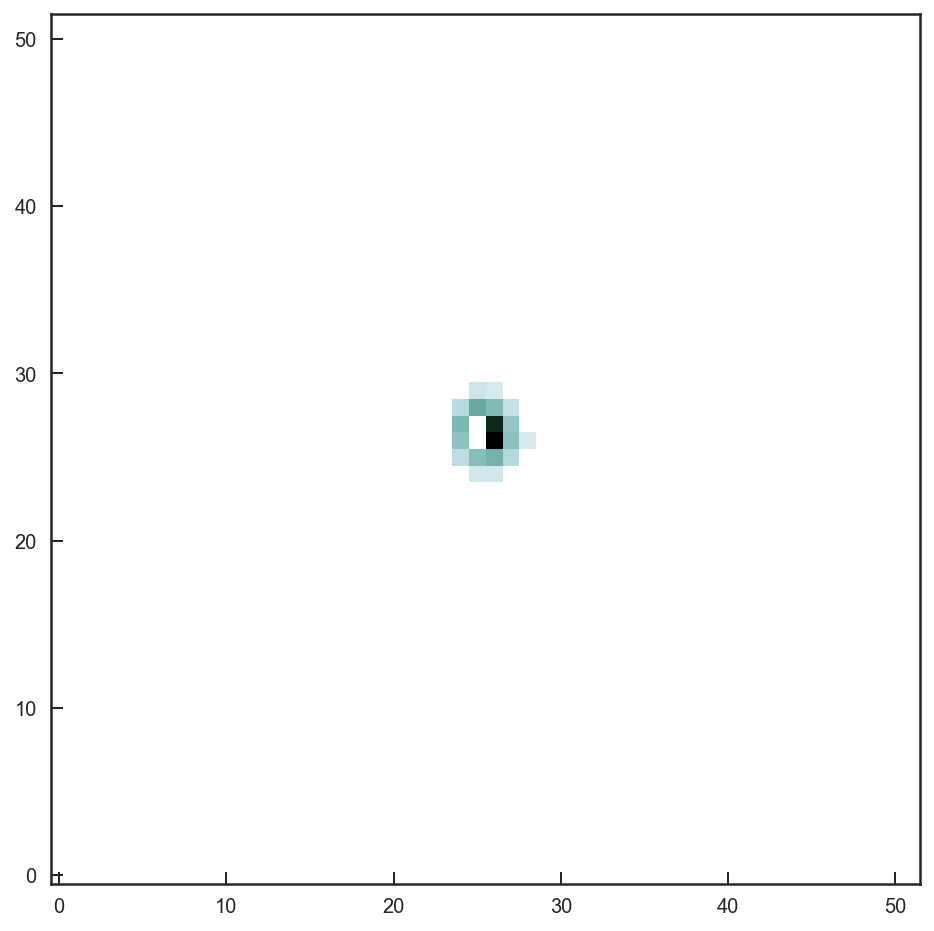

In [65]:
%matplotlib inline

## Spectrum cutouts
beam_g102 = grizli.model.BeamCutout(sim_g102, beam=sim_g102.object_dispersers[id]['A'], conf=sim_g102.conf)

###show cutout
plt.figure(figsize=[8,8])
plt.imshow(beam_g102.beam.direct*(beam_g102.beam.seg == gid), interpolation='Nearest', cmap=colmap, origin='lower')
plt.show()
plt.close()

Create spectra to forward model 

In [72]:
wv = np.arange(2000,7000,.1)
flx = Gauss_dist(wv,4100,5)
SNR = 10
er = flx / SNR
redshift = 1.3
wv_obs = wv * (1 + redshift)

Create simluted grism

In [115]:
## create basis model for sim
spec = S.ArraySpectrum(wv, flx, fluxunits='flam')
spec = spec.redshift(redshift).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
spec.convert('flam')

## Compute the models
beam_g102.compute_model(spectrum_1d=[spec.wave, spec.flux])

## Extractions the model (error array here is meaningless)
w, f, e = beam_g102.beam.optimal_extract(beam_g102.model, bin=0)

## Get sensitivity function
sens_wv, sens_fl = [beam_g102.beam.lam, beam_g102.beam.sensitivity / np.max(beam_g102.beam.sensitivity)]

## adjust model flux  
IDX = [U for U in range(len(wv_obs)) if 8000 < wv_obs[U] < 11000]

isens = interp1d(sens_wv, sens_fl)(wv_obs[IDX])

ifl = interp1d(w, f)(wv_obs[IDX])

C = Scale_model(flx[IDX], er[IDX], ifl / isens)

##trim and save outputs
IDX = [U for U in range(len(w)) if 8000 <= w[U] <= 11300]

mfl = C * f[IDX] / sens_fl[IDX]
mwv = w[IDX]
mer =np.mean(f[IDX]) / sens_fl[IDX]
mer /=np.trapz(mer,mwv)
mer *= np.trapz(mfl,mwv) / SNR

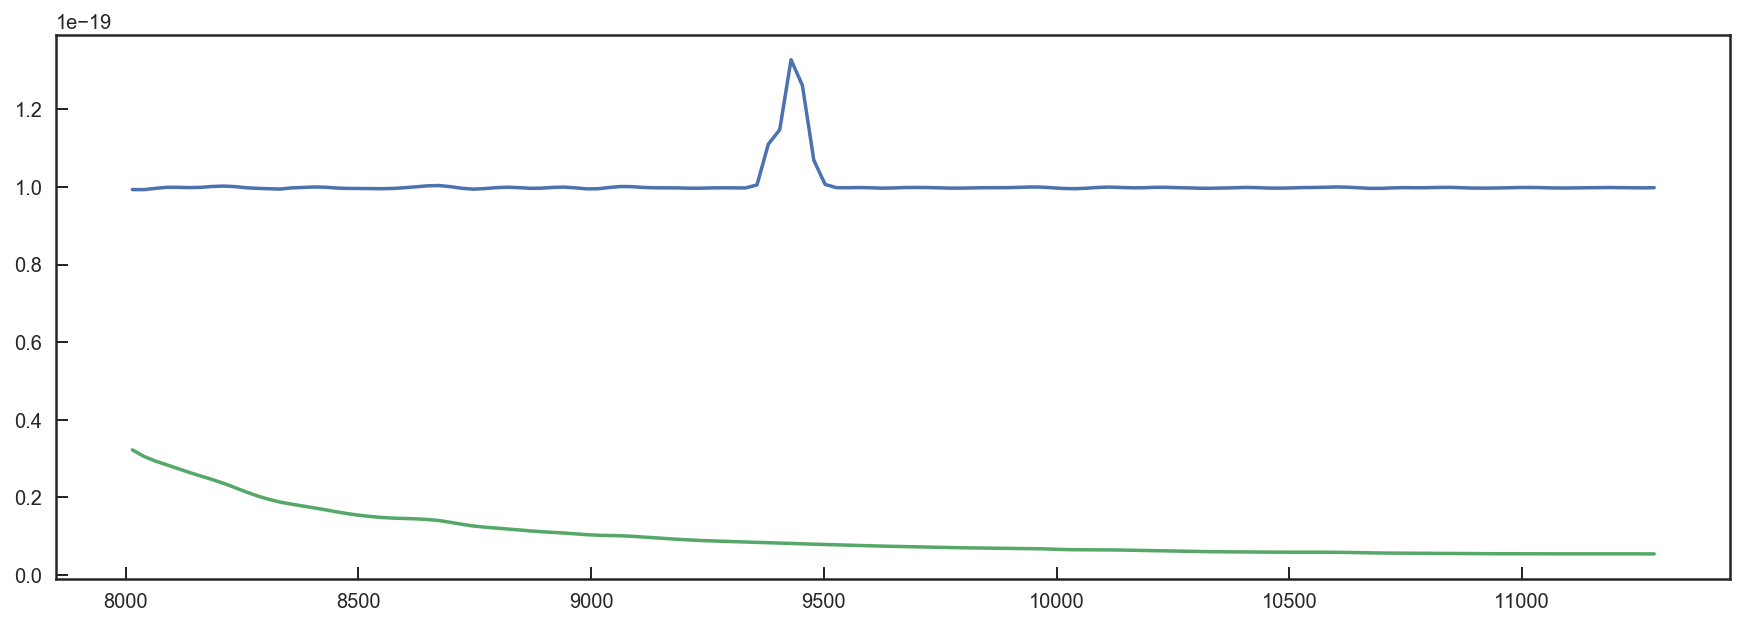

In [116]:
plt.figure(figsize=[15,5])
plt.plot(w[IDX],mfl)
plt.plot(w[IDX],mer)

Plot 2D and 1D spectra, compare 1D to original.

(8000, 11300)

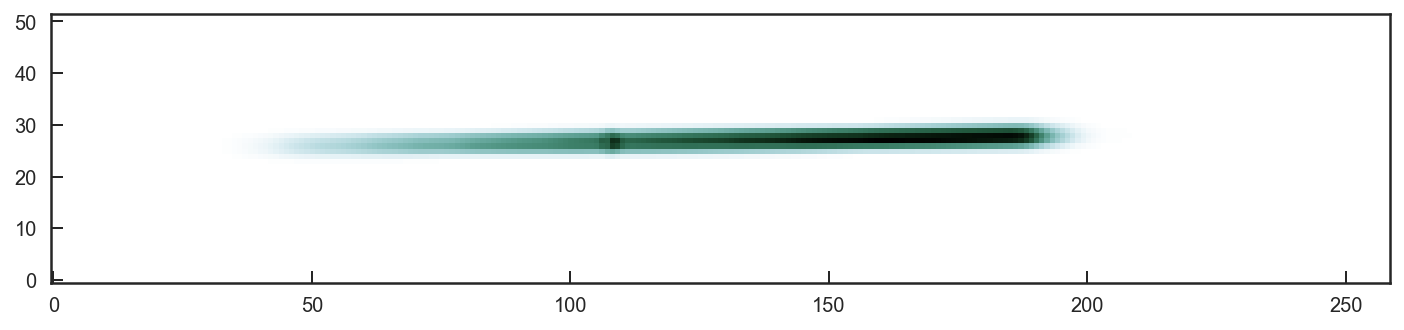

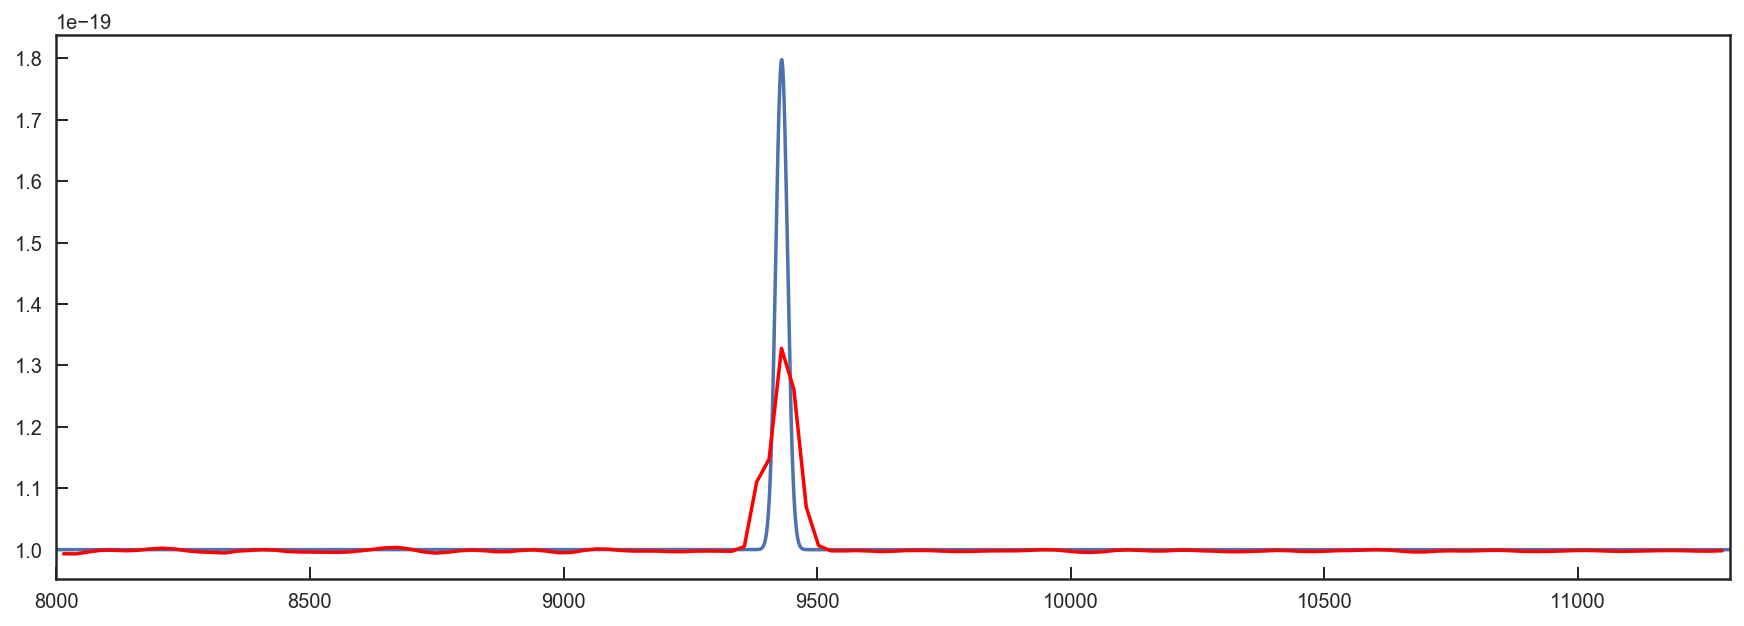

In [75]:
###Show Grism
plt.figure(figsize=[12,8])
plt.subplot(211)
plt.imshow(beam_g102.model, interpolation='Nearest', origin='lower', cmap=colmap)

###plot 1D spectra
plt.figure(figsize=[15,5])
plt.plot(wv_obs,flx)
plt.plot(mwv,mfl,'r')
plt.xlim(8000,11300)

In [132]:
class Gen_sim(object):
    def __init__(self, redshift, wavelength, flux, signal_to_noise, minwv = 8000, maxwv = 11300):
        import pysynphot as S
        self.redshift = redshift
        self.wv = wavelength
        self.wv_obs = self.wv * (1 + self.redshift)
        self.fl = flux
        self.SNR = signal_to_noise
        self.er = self.fl / self.SNR
        """ 
        self.flt_input - image flt which contains the object you're interested in modeling 
        **
        self.beam - information used to make models
        **
        self.redshift - redshift of simulation
        **
        self.wv - input wavelength array of spectrum
        **
        self.wv_obs - input wavelength array of spectrum
        **
        self.fl - input flux array
        **
        self.er - output error array 
        **
        self.SNR - signal to noise ratio used to generate error
        **
        self.mfl - forward modeled flux array
        **
        self.mfl - forward modeled flux array
        **        
        self.mwv - output wavelength array in the observed frame
        **
        self.flx_err - output flux array of spectra perturb by the errors

        """      
        
        ## set flt file, we're using a good example galaxy
        self.flt_input = 's47677_flt.fits' 


        ## Create Grizli model object
        sim_g102 = grizli.model.GrismFLT(grism_file='', verbose=False,
                                         direct_file=self.flt_input,
                                         force_grism='G102')

        sim_g102.photutils_detection(detect_thresh=.025, verbose=True, save_detection=True)

        keep = sim_g102.catalog['mag'] < 29
        c = sim_g102.catalog

        sim_g102.compute_full_model(ids=c['id'][keep], mags=c['mag'][keep], verbose=False)

        ## Grab object near the center of the image
        dr = np.sqrt((sim_g102.catalog['x_flt'] - 579) ** 2 + (sim_g102.catalog['y_flt'] - 522) ** 2)
        ix = np.argmin(dr)
        id = sim_g102.catalog['id'][ix]

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(sim_g102, beam=sim_g102.object_dispersers[id]['A'], conf=sim_g102.conf)

        ## create basis model for sim
        spec = S.ArraySpectrum(self.wv, self.fl, fluxunits='flam')
        spec = spec.redshift(self.redshift).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
        spec.convert('flam')
        
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[spec.wave, spec.flux])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(self.beam.model, bin=0)

        ## Get sensitivity function
        sens_wv, sens_fl = [self.beam.beam.lam, self.beam.beam.sensitivity / np.max(self.beam.beam.sensitivity)]

        ## adjust model flux  
        IDX = [U for U in range(len(self.wv_obs)) if 8000 < self.wv_obs[U] < 11000]
        
        isens = interp1d(sens_wv, sens_fl)(self.wv_obs[IDX])

        ifl = interp1d(w, f)(self.wv_obs[IDX])

        C = Scale_model(self.fl[IDX], self.er[IDX], ifl / isens)
               
        ##trim and save outputs
        IDX = [U for U in range(len(w)) if minwv <= w[U] <= maxwv]

        self.mfl = C * f[IDX] / sens_fl[IDX]
        self.mwv = w[IDX]
        self.mer = np.mean(f[IDX]) / sens_fl[IDX]
        self.mer /= np.trapz(self.mer,self.mwv)
        self.mer *= np.trapz(self.mfl,self.mwv) / self.SNR
        
        
    def Sim_data(self):
        self.flx_err = np.abs(self.mfl + np.random.normal(0, self.mer))

In [133]:
def Gauss_dist(x, mu, sigma):
    G = (1. / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return (G + .1)*1E-18

In [134]:
wv = np.arange(2000,7000,.1)
flx = Gauss_dist(wv,4100,1)

In [145]:
test = Gen_sim(redshift=1.2,wavelength=wv,flux=flx,signal_to_noise=20)

s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
s47677_flt: photutils.source_properties - 1 objects
s47677_flt: save s47677_flt.detect_seg.fits, s47677_flt.detect.cat


In [146]:
test.Sim_data()

(8000, 11300)

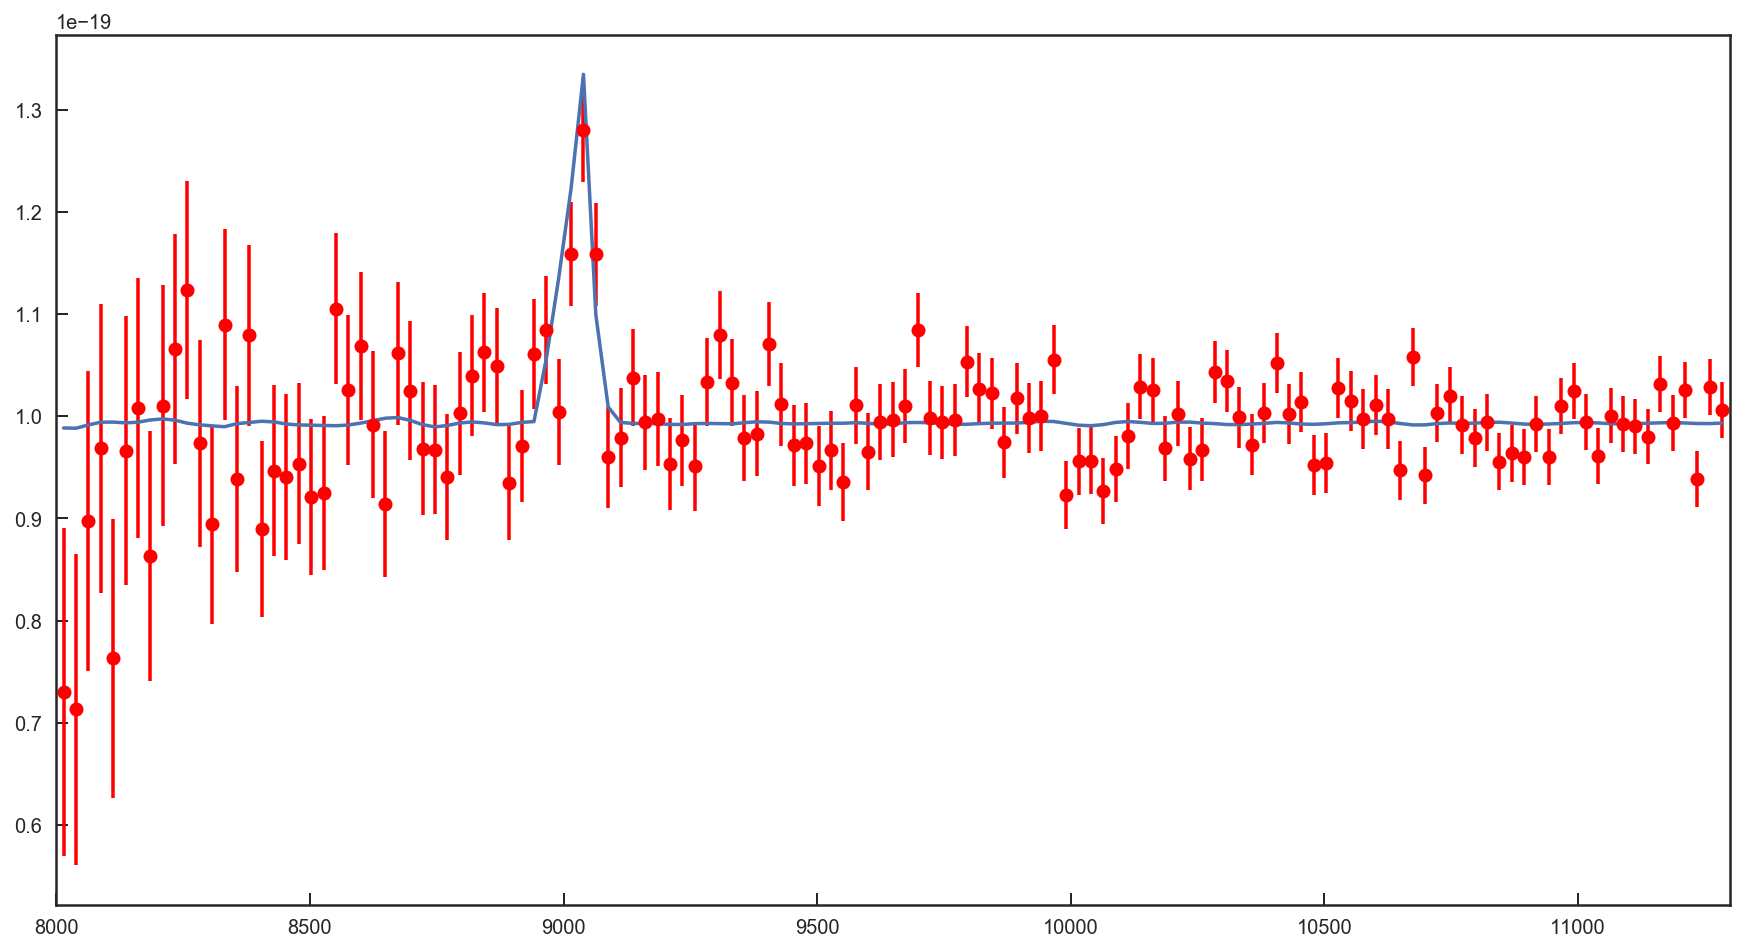

In [147]:
plt.figure(figsize=[15,8])
# plt.plot(test.wv_obs,test.fl)
plt.plot(test.mwv,test.mfl)
plt.errorbar(test.mwv,test.flx_err,test.mer,fmt = 'ro')
plt.xlim(8000,11300)